# Partie 2 : Déploiement et quantization avec ONNX

### 1. Entrainement d'un CNN simple avec PyTorch et sur le dataset Fashion-MNIST

In [46]:
# Check if cuda is available
import torch
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: True


In [16]:
import torch
import torch.nn as nn

# We define a simple convolutional neural network for the Fashion-MNIST dataset
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = CNN()
print(net)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [17]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import matplotlib.pyplot as plt

batch_size = 64

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the Fashion-MNIST dataset with transforms
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print("Number of training samples:", len(train_dataset))
print("Number of test samples:", len(test_dataset))
print("Sample label:", train_dataset[0][1])
print("Dataset classes:", train_dataset.classes)

Number of training samples: 60000
Number of test samples: 10000
Sample label: 9
Dataset classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Epoch [1, 100] loss: 0.385
Epoch [1, 200] loss: 0.342
Epoch [1, 300] loss: 0.334
Epoch [1, 400] loss: 0.299
Epoch [1, 500] loss: 0.301
Epoch [1, 600] loss: 0.305
Epoch [1, 700] loss: 0.290
Epoch [1, 800] loss: 0.287
Epoch [1, 900] loss: 0.272
Epoch [2, 100] loss: 0.270
Epoch [2, 200] loss: 0.254
Epoch [2, 300] loss: 0.242
Epoch [2, 400] loss: 0.238
Epoch [2, 500] loss: 0.263
Epoch [2, 600] loss: 0.243
Epoch [2, 700] loss: 0.234
Epoch [2, 800] loss: 0.239
Epoch [2, 900] loss: 0.235
Epoch [3, 100] loss: 0.204
Epoch [3, 200] loss: 0.202
Epoch [3, 300] loss: 0.213
Epoch [3, 400] loss: 0.215
Epoch [3, 500] loss: 0.214
Epoch [3, 600] loss: 0.199
Epoch [3, 700] loss: 0.201
Epoch [3, 800] loss: 0.216
Epoch [3, 900] loss: 0.214
Epoch [4, 100] loss: 0.175
Epoch [4, 200] loss: 0.179
Epoch [4, 300] loss: 0.177
Epoch [4, 400] loss: 0.179
Epoch [4, 500] loss: 0.191
Epoch [4, 600] loss: 0.190
Epoch [4, 700] loss: 0.170
Epoch [4, 800] loss: 0.183
Epoch [4, 900] loss: 0.186
Epoch [5, 100] loss: 0.148
E

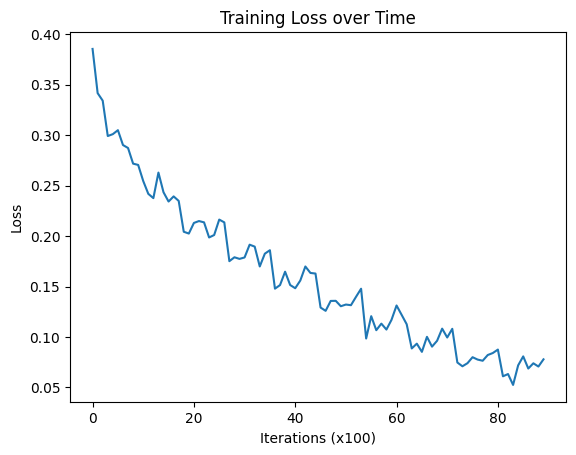

In [23]:
# Define loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)
losses = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'Epoch [{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}')
            losses.append(running_loss / 100)
            running_loss = 0.0

# Display training loss
plt.plot(losses)
plt.xlabel('Iterations (x100)')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.show()

In [24]:
# Test the network
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 91.2 %


In [ ]:
import torch.onnx

# Export the model to ONNX format
onnx_file_path = "fashion_mnist_cnn.onnx"

net.eval()

dummy_input = torch.randn(1, 1, 28, 28, requires_grad=True).to(device)

input_names = ["input"]
output_names = ["output"]

dynamic_axes = {'input': {0: 'batch_size'},
                'output': {0: 'batch_size'}}


# Perform the export
torch.onnx.export(
    net,
    dummy_input,
    onnx_file_path,
    export_params=True,
    opset_version=17,
    do_constant_folding=True,
    input_names=input_names,
    output_names=output_names,
    dynamic_axes=dynamic_axes
)

print(f"Model successfully exported to {onnx_file_path}")

Model successfully exported to fashion_mnist_cnn.onnx


/tmp/ipykernel_18157/2155208815.py:29: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


### 2. Benchmarking du modele

On mesure le temps moyen de prédiction du modèle original et le modèle onnx CPU (pour une comparaison equitable) pour différentes tailles de batch.

In [45]:
import onnxruntime
import numpy as np
import time
from tabulate import tabulate
import torch

def benchmark_pytorch_model(model, input_shape, batch_sizes=[1, 8, 32, 128], num_runs=100):
    results = {}
    model.eval()
    
    channels, height, width = input_shape
    
    for batch_size in batch_sizes:
        dummy_input = torch.randn(batch_size, channels, height, width).to(device)
        
        # Warmup
        for _ in range(10):
            _ = model(dummy_input)
        
        start_time = time.time()
        with torch.no_grad():
            for _ in range(num_runs):
                _ = model(dummy_input)
        end_time = time.time()
        
        avg_time = (end_time - start_time) * 1000 / num_runs
        results[batch_size] = avg_time
    
    return results

def benchmark_onnx_model(onnx_path, input_shape, batch_sizes=[1, 8, 32, 128], num_runs=100):
    results = {}
    
    session = onnxruntime.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])
    input_name = session.get_inputs()[0].name
    
    channels, height, width = input_shape
    
    for batch_size in batch_sizes:
        dummy_input = np.random.randn(batch_size, channels, height, width).astype(np.float32)
        
        # Warmup
        for _ in range(10):
            _ = session.run(None, {input_name: dummy_input})
        
        start_time = time.time()
        for _ in range(num_runs):
            _ = session.run(None, {input_name: dummy_input})
        end_time = time.time()
        
        avg_time = (end_time - start_time) * 1000 / num_runs
        results[batch_size] = avg_time
    
    return results
    

# Move model to CPU for fair comparison
net = net.cpu()
device = torch.device("cpu")
input_shape = (1, 28, 28)  # Fashion-MNIST images are 28x28x1

batch_sizes = [1, 8, 32, 128]
pytorch_results = benchmark_pytorch_model(net, input_shape, batch_sizes)
onnx_results = benchmark_onnx_model("fashion_mnist_cnn.onnx", input_shape, batch_sizes)

# Prepare results table
headers = ["Model"] + [f"Batch Size {bs}" for bs in batch_sizes]
data = [
    ["PyTorch (ms)"] + [f"{pytorch_results[bs]:.2f}" for bs in batch_sizes],
    ["ONNX Runtime (ms)"] + [f"{onnx_results[bs]:.2f}" for bs in batch_sizes]
]

print("\nInference time in milliseconds (lower is better):")
print(tabulate(data, headers=headers, tablefmt="grid"))


Inference time in milliseconds (lower is better):
+-------------------+----------------+----------------+-----------------+------------------+
| Model             |   Batch Size 1 |   Batch Size 8 |   Batch Size 32 |   Batch Size 128 |
+===================+================+================+=================+==================+
| PyTorch (ms)      |           0.29 |           1.24 |            4.54 |            17.12 |
+-------------------+----------------+----------------+-----------------+------------------+
| ONNX Runtime (ms) |           0.12 |           0.36 |            1.36 |             0.74 |
+-------------------+----------------+----------------+-----------------+------------------+


Comparaison de la test accuracy entre le modèle PyTorch et le modèle ONNX exporté.

In [31]:
from scipy.special import softmax
import torch.nn.functional as F

def compare_predictions(pytorch_model, onnx_path, test_loader, num_samples=5):
    pytorch_model.eval()
    session = onnxruntime.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])
    input_name = session.get_inputs()[0].name
    
    correct_pytorch = 0
    correct_onnx = 0
    total = 0
    
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Calculate accuracy and compare predictions
    with torch.no_grad():
        # PyTorch predictions
        pytorch_outputs = pytorch_model(images)
        _, predicted_pytorch = torch.max(pytorch_outputs.data, 1)
        correct_pytorch += (predicted_pytorch == labels).sum().item()
        
        # ONNX Runtime predictions
        onnx_outputs = session.run(None, {input_name: images.numpy()})
        predicted_onnx = np.argmax(onnx_outputs[0], axis=1)
        correct_onnx += (predicted_onnx == labels.numpy()).sum()
        
        total += labels.size(0)
        
        print("\nDetailed comparison of first", num_samples, "samples:")
        print("-" * 50)
        
        pytorch_softmax = F.softmax(pytorch_outputs, dim=1).numpy()
        onnx_softmax = softmax(onnx_outputs[0], axis=1)
        
        for i in range(num_samples):
            print(f"\nSample {i+1}:")
            print(f"True label: {labels[i]}")
            print(f"PyTorch prediction: {predicted_pytorch[i]} (confidence: {pytorch_softmax[i][predicted_pytorch[i]]:.4f})")
            print(f"ONNX prediction: {predicted_onnx[i]} (confidence: {onnx_softmax[i][predicted_onnx[i]]:.4f})")
            print(f"Max difference in softmax outputs: {np.max(np.abs(pytorch_softmax[i] - onnx_softmax[i])):.6f}")
    
    print("\nOverall Results:")
    print(f"PyTorch Accuracy: {100 * correct_pytorch / total:.2f}%")
    print(f"ONNX Runtime Accuracy: {100 * correct_onnx / total:.2f}%")
    
    return pytorch_softmax, onnx_softmax

net = net.cpu()
net.eval()

pytorch_softmax, onnx_softmax = compare_predictions(net, "fashion_mnist_cnn.onnx", test_loader)


Detailed comparison of first 5 samples:
--------------------------------------------------

Sample 1:
True label: 9
PyTorch prediction: 9 (confidence: 1.0000)
ONNX prediction: 9 (confidence: 1.0000)
Max difference in softmax outputs: 0.000000

Sample 2:
True label: 2
PyTorch prediction: 2 (confidence: 1.0000)
ONNX prediction: 2 (confidence: 1.0000)
Max difference in softmax outputs: 0.000000

Sample 3:
True label: 1
PyTorch prediction: 1 (confidence: 1.0000)
ONNX prediction: 1 (confidence: 1.0000)
Max difference in softmax outputs: 0.000000

Sample 4:
True label: 1
PyTorch prediction: 1 (confidence: 1.0000)
ONNX prediction: 1 (confidence: 1.0000)
Max difference in softmax outputs: 0.000000

Sample 5:
True label: 6
PyTorch prediction: 6 (confidence: 0.9483)
ONNX prediction: 6 (confidence: 0.9483)
Max difference in softmax outputs: 0.000000

Overall Results:
PyTorch Accuracy: 87.50%
ONNX Runtime Accuracy: 87.50%


_4. Mesurer la test accuracy de votre modèle avec ONNX runtime et comparer les softpredictions sur plusieurs exemples. y-t-il des différences ?_

On remarque que les tests accuracies sont équivalentes entre les deux modèles.

### 3. Quantification du modèle ONNX

In [32]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

model_fp32 = "fashion_mnist_cnn.onnx"
model_quant = "fashion_mnist_cnn_quantized.onnx"

quantize_dynamic(
    model_input=model_fp32,
    model_output=model_quant,
    weight_type=QuantType.QUInt8
)

import os

original_size = os.path.getsize(model_fp32) / (1024 * 1024)  # Size in MB
quantized_size = os.path.getsize(model_quant) / (1024 * 1024)  # Size in MB

print(f"Original model size: {original_size:.2f} MB")
print(f"Quantized model size: {quantized_size:.2f} MB")
print(f"Size reduction: {(1 - quantized_size/original_size)*100:.2f}%")

Original model size: 1.61 MB
Quantized model size: 0.41 MB
Size reduction: 74.63%


### Benchmark du modèle quantifié

In [33]:
quant_results = benchmark_onnx_model(model_quant, batch_sizes)

headers = ["Model"] + [f"Batch Size {bs}" for bs in batch_sizes]
data = [
    ["PyTorch (ms)"] + [f"{pytorch_results[bs]:.2f}" for bs in batch_sizes],
    ["ONNX FP32 (ms)"] + [f"{onnx_results[bs]:.2f}" for bs in batch_sizes],
    ["ONNX INT8 (ms)"] + [f"{quant_results[bs]:.2f}" for bs in batch_sizes]
]

print("\nInference time in milliseconds (lower is better):")
print(tabulate(data, headers=headers, tablefmt="grid"))

print("\nComparing accuracy between original and quantized models:")
_, _ = compare_predictions(net, model_quant, test_loader)


Inference time in milliseconds (lower is better):
+----------------+----------------+----------------+-----------------+------------------+
| Model          |   Batch Size 1 |   Batch Size 8 |   Batch Size 32 |   Batch Size 128 |
+================+================+================+=================+==================+
| PyTorch (ms)   |           0.3  |           1.04 |            4.03 |            16.52 |
+----------------+----------------+----------------+-----------------+------------------+
| ONNX FP32 (ms) |           0.09 |           0.44 |            1.56 |             6.19 |
+----------------+----------------+----------------+-----------------+------------------+
| ONNX INT8 (ms) |           0.15 |           0.6  |            2.06 |            12.31 |
+----------------+----------------+----------------+-----------------+------------------+

Comparing accuracy between original and quantized models:

Detailed comparison of first 5 samples:
---------------------------------------

### Meme analyse mais avec un dataset plus large (CIFAR-10) et un modèle plus complexe (ResNet18).

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

model = torchvision.models.resnet18(pretrained=True)

# Modify the last layer for CIFAR-10 (10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model architecture:", model)
print("\nCIFAR-10 Classes:", trainset.classes)

100%|██████████| 170M/170M [00:06<00:00, 25.2MB/s] 
/home/leon/miniconda3/envs/mlops/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leon/miniconda3/envs/mlops/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/leon/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s] 


Model architecture: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

#### Fine-tuning sur CIFAR-10

In [36]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
losses = []

# Fine-tuning loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch [{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}')
            losses.append(running_loss / 100)
            running_loss = 0.0

# Test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Epoch [1, 100] loss: 2.497
Epoch [1, 200] loss: 1.906
Epoch [1, 300] loss: 1.749
Epoch [1, 400] loss: 1.568
Epoch [1, 500] loss: 1.389
Epoch [1, 600] loss: 1.295
Epoch [1, 700] loss: 1.153
Epoch [2, 100] loss: 1.026
Epoch [2, 200] loss: 0.969
Epoch [2, 300] loss: 0.948
Epoch [2, 400] loss: 0.922
Epoch [2, 500] loss: 0.909
Epoch [2, 600] loss: 0.862
Epoch [2, 700] loss: 0.814
Epoch [3, 100] loss: 0.757
Epoch [3, 200] loss: 0.777
Epoch [3, 300] loss: 0.773
Epoch [3, 400] loss: 0.736
Epoch [3, 500] loss: 0.716
Epoch [3, 600] loss: 0.698
Epoch [3, 700] loss: 0.691
Epoch [4, 100] loss: 0.628
Epoch [4, 200] loss: 0.629
Epoch [4, 300] loss: 0.611
Epoch [4, 400] loss: 0.599
Epoch [4, 500] loss: 0.617
Epoch [4, 600] loss: 0.618
Epoch [4, 700] loss: 0.591
Epoch [5, 100] loss: 0.466
Epoch [5, 200] loss: 0.496
Epoch [5, 300] loss: 0.487
Epoch [5, 400] loss: 0.520
Epoch [5, 500] loss: 0.535
Epoch [5, 600] loss: 0.535
Epoch [5, 700] loss: 0.516
Epoch [6, 100] loss: 0.413
Epoch [6, 200] loss: 0.429
E

#### Export vers ONNX

In [37]:
model.eval()
dummy_input = torch.randn(1, 3, 32, 32).to(device)  # CIFAR-10 images are 32x32x3

torch.onnx.export(
    model,
    dummy_input,
    "resnet18_cifar10.onnx",
    export_params=True,
    opset_version=17,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'},
                 'output': {0: 'batch_size'}}
)

/tmp/ipykernel_18157/1095535220.py:4: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


#### Quantization du modèle ONNX et benchmark

In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType

# Quantize the model
model_fp32 = "resnet18_cifar10.onnx"
model_quant = "resnet18_cifar10_quantized.onnx"

quantize_dynamic(
    model_input=model_fp32,
    model_output=model_quant,
    weight_type=QuantType.QUInt8
)

model = model.cpu()
device = torch.device("cpu")

# Benchmark all models
batch_sizes = [1, 8, 32, 128]
input_shape = (3, 32, 32)  # CIFAR-10 dimensions
pytorch_results = benchmark_pytorch_model(model, input_shape, batch_sizes)
onnx_results = benchmark_onnx_model(model_fp32, input_shape, batch_sizes)
quant_results = benchmark_onnx_model(model_quant, input_shape, batch_sizes)

# Compare results
headers = ["Model"] + [f"Batch Size {bs}" for bs in batch_sizes]
data = [
    ["PyTorch (ms)"] + [f"{pytorch_results[bs]:.2f}" for bs in batch_sizes],
    ["ONNX FP32 (ms)"] + [f"{onnx_results[bs]:.2f}" for bs in batch_sizes],
    ["ONNX INT8 (ms)"] + [f"{quant_results[bs]:.2f}" for bs in batch_sizes]
]

print("\nInference time in milliseconds (lower is better):")
print(tabulate(data, headers=headers, tablefmt="grid"))

print("\nComparing accuracy between models:")
pytorch_softmax, onnx_softmax = compare_predictions(model, model_fp32, testloader)
print("\nComparing accuracy with quantized model:")
_, _ = compare_predictions(model, model_quant, testloader)


Inference time in milliseconds (lower is better):
+----------------+----------------+----------------+-----------------+------------------+
| Model          |   Batch Size 1 |   Batch Size 8 |   Batch Size 32 |   Batch Size 128 |
+================+================+================+=================+==================+
| PyTorch (ms)   |           4.34 |           7.42 |           18.9  |            41.48 |
+----------------+----------------+----------------+-----------------+------------------+
| ONNX FP32 (ms) |           1.1  |           2.58 |            7.51 |            23.33 |
+----------------+----------------+----------------+-----------------+------------------+
| ONNX INT8 (ms) |           1.55 |           8.74 |           26.16 |           117.96 |
+----------------+----------------+----------------+-----------------+------------------+

Comparing accuracy between models:

Detailed comparison of first 5 samples:
--------------------------------------------------

Sample 1:
